In [1]:
from PIL import Image
import numpy as np
import scipy.stats as stats
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
basedir = "./pics_/"
filelist = os.listdir(basedir)
filelist.sort()
print (len(filelist))

40


In [3]:
def nse(p):  # normalized shannon entropy
    return (stats.entropy(p) / np.log(p.shape[0]))

def D(p, u): # equation 3
    return nse((p+u)/2) - nse(p/2) - nse(u/2)

- **Normalized Permutation Entropy (H)** quantifies the degree of disorder in the pixel arrangement of an image: Values close to 1 indicate that pixels appear at random, while values close to zero indicate that pixels appear almost always in the same order.
- **Statistical complexity (C)** measures the “structural” complexity present in an image: It is zero for both extremes of order and disorder in the pixel arrangement, and it is positive when an image presents more-complex spatial patterns.


In [38]:
with open("outputs.csv", "w") as ofh:
    s1 = "filename,complexity,entropy"
    print (s1)
    ofh.write(s1+"\n")
    for fnn in filelist[25:34]:
        # data preparation etc.
        filename = basedir+fnn
        img = Image.open(filename)
        idata = np.asarray(img)
        idata = np.uint32(np.mean(idata, axis=2)) # arithmetic mean, as done by the paper
        img2 = Image.fromarray(idata)    
        COLMAX, ROWMAX = img2.size # Get image size (width, height) i.e. column followed by row

        # ==== algorithm begins ====

        argsort_results = np.uint32(np.zeros([(ROWMAX-1)*(COLMAX-1), 4]))
        acounter = 0
        for i in np.arange(0, ROWMAX-1, 1):
            for j in np.arange(0, COLMAX-1, 1):
                window1 = idata[i:i+2, j:j+2]  # plus 2 makes it 2x2, otherwise becomes 1x1
                wflat = window1.flatten()
                argsort1 = np.uint32(np.argsort(wflat, kind='stable')) # mentioned in paper: in case of tie, preserve original order
                argsort_results[acounter] = argsort1
                acounter = acounter+1

        elements, counts = np.unique(argsort_results, axis=0, return_counts=True)
        n = 24
        p = counts / n  # probability distribution
        h = nse(p) # normalized shannon entropy... equation 1
        Dstar = -0.5 * ( (n+1)/n*np.log(n+1) + np.log(n) - 2*np.log(2*n) ) # equation 4
        u = np.array([1/n]*elements.shape[0]) # uniform distribution
        C = (D(p,u) * h) / Dstar # Equation 2

        # ==== algoithm ends ====
        s2 = f"{fnn},{C:.8f},{h:.8f}"
        print (s2)
        ofh.write(s2+"\n")

filename,complexity,entropy
UL (32).png,-1.14024350,0.69063543
UL (33).png,-1.41985746,0.85998730
UL (34).png,-1.08294760,0.65593383
UL (35).png,-1.11323638,0.67427895
UL (36).png,-1.15902374,0.70201103
UL (37).png,-0.98577868,0.59708220
UL (38).png,-1.05799694,0.64082338
UL (39).png,-1.21749942,0.73742636
UL (4).png,-1.02693371,0.62201065


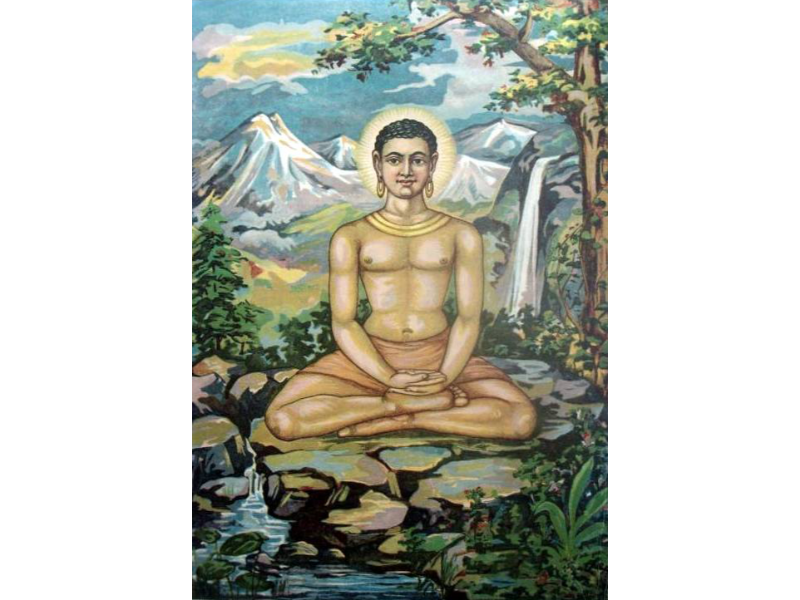

In [39]:
img

In [40]:
cedf = pd.read_csv('outputs.csv')
cedf.head()

,filename,complexity,entropy
0,UL (32).png,-1.140243,0.690635
1,UL (33).png,-1.419857,0.859987
2,UL (34).png,-1.082948,0.655934
3,UL (35).png,-1.113236,0.674279
4,UL (36).png,-1.159024,0.702011


Text(0.5, 0, 'Entropy')

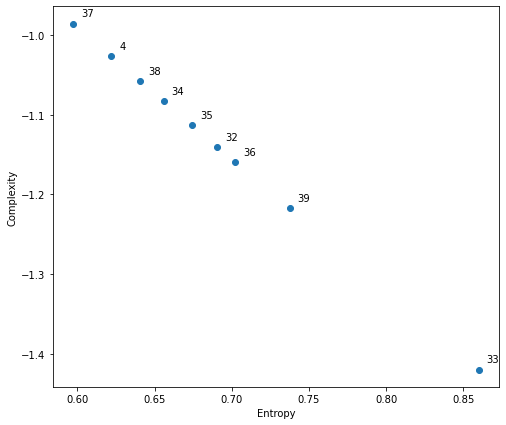

In [41]:
x = cedf['entropy']
y = cedf['complexity']
labels = cedf['filename']
labels = [s1[s1.find("(")+1:s1.find(")")] for s1 in labels] # only numbers, discard "UL" and ".png"

f = plt.figure(figsize=(8,7))
ax = f.gca()
ax.scatter(x, y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]), xytext = (8,7), textcoords="offset points") # https://stackoverflow.com/a/60786569

ax.set_ylabel("Complexity")
ax.set_xlabel("Entropy")